<a href="https://colab.research.google.com/github/FlyStarYm/FlyStarYm.github.io/blob/master/Breakout_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1.Installing and importing dependencies**

In [ ]:
!pip install stable-baselines[mpi]==2.8.0
!gdown -q http://www.atarimania.com/roms/Roms.rar
!pip install -q unrar
!mkdir ./roms_atari
!unrar x Roms.rar ./roms_atari > /dev/null 2>&1
!python -m atari_py.import_roms ./roms_atari > /dev/null 2>&1

  Using cached stable_baselines-2.8.0-py3-none-any.whl (222 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.5 MB/s eta 0:00:00
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp310-cp310-linux_x86_64.whl size=2744867 sha256=5eb5294475a660967ef490e104ca58df890f6606e5492adea7ff2824f5454ac9
  Stored in directory: /root/.cache/pip/wheels/e8/1b/b5/97ec4cfccdde26e0f3590ad6e09a5242d508dff09704ef86c1
Successfully built mpi4py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.0
    Uninstalling pygame-2.5.0:
      Successfully uninstalled pygame-2.5.0
mkdir: cannot create directory ‘./roms_atari’: File exists


In [ ]:
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from google.colab import drive
import gym.wrappers
drive.mount('/content/gdrive', force_remount=True)

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/gdrive


In [ ]:
!pip install git+https://github.com/Kojoley/atari-py.git
!pip install gym[atari]

  Cloning https://github.com/Kojoley/atari-py.git to /tmp/pip-req-build-302b1g_i
  Running command git clone --filter=blob:none --quiet https://github.com/Kojoley/atari-py.git /tmp/pip-req-build-302b1g_i
  Resolved https://github.com/Kojoley/atari-py.git to commit 86a1e05c0a95e9e6233c3a413521fdb34ca8a089
  Preparing metadata (setup.py) ... done
  Created wheel for atari-py: filename=atari_py-1.2.2-cp310-cp310-linux_x86_64.whl size=4738552 sha256=2ac691437dc65a46ee2b62ad8f05c39eddb81366ed9753d2202b59c881e93f5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-bzstlxrv/wheels/6c/9b/f1/8a80a63a233d6f4eb2e2ee8c7357f4875f21c3ffc7f2613f9f
Successfully built atari-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00


### **2.Examining the Breakout environment**

(210, 160, 3)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


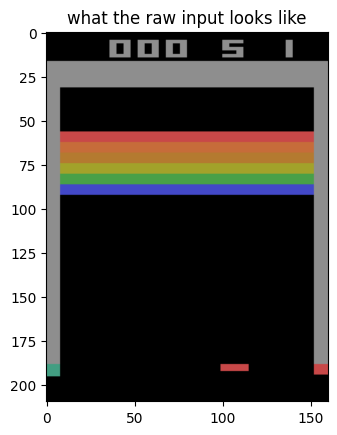

In [ ]:
# Observations (raw)
import gym
env = gym.make("BreakoutNoFrameskip-v4")
#env = make_atari("BreakoutNoFrameskip-v4")
obs = np.array(env.reset())
print(obs.shape)
plt.title("what the raw input looks like")
plt.imshow(obs)

(84, 84, 4)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


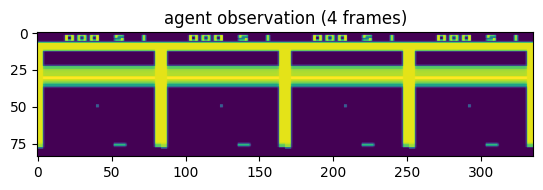

In [ ]:
# Observations (wrapped)
import gym
env = gym.make("BreakoutNoFrameskip-v4")
env = wrap_deepmind(env, frame_stack=True, scale=True)
obs = np.array(env.reset())

print(obs.shape)
plt.title("agent observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))

In [ ]:
# Actions
print(env.action_space)
print(env.get_action_meanings())

Discrete(4)
['NOOP', 'FIRE', 'RIGHT', 'LEFT']


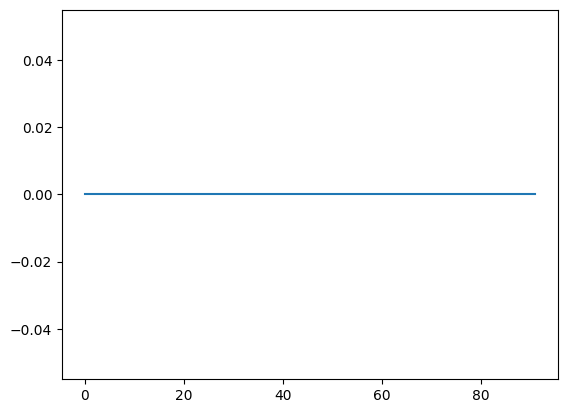

In [ ]:
# Rewards
env.reset()
rewards = []
while True:
  obs, rew, done, info = env.step(env.action_space.sample())
  rewards.append(rew)
  if done:
    break
plt.plot(rewards)

### **3.Creating a model - Deep convolutional neural network**

In [ ]:
num_actions = 4
def create_q_model():
  # Network defined by the Deepmind paper
  inputs = layers.Input(shape=(84, 84, 4,))
  layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
  layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
  layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)
  layer4 = layers.Flatten()(layer3)
  layer5 = layers.Dense(512, activation="relu")(layer4)
  action = layers.Dense(num_actions, activation="linear")(layer5)

  return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make an action.
model = create_q_model()
# Target model
model_target = create_q_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1606144   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052  

### **4.Configuring the hyperparameters and model training**

In [ ]:
gamma = 0.99 # Discount factor for past rewards

# Setting epsilon decay parameters
epsilon = 1.0
epsilon_max_1 = 1.0
epsilon_min_1 = 0.2
epsilon_max_2 = epsilon_min_1
epsilon_min_2 = 0.1
epsilon_max_3 = epsilon_min_2
epsilon_min_3 = 0.02

epsilon_interval_1 = (epsilon_max_1 - epsilon_min_1)
epsilon_interval_2 = (epsilon_max_2 - epsilon_min_2)
epsilon_interval_3 = (epsilon_max_3 - epsilon_min_3)

# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000

# Maximum Replay Buffer volume
max_memory_length = 190000

# Size of batch taken from replay buffer
batch_size = 32
max_steps_per_episode = 10000

# Train the model after 20 actions
update_after_actions = 20

# How often to update the target network
update_target_network = 10000

# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm = 1.0)

# Using huber loss for stability
loss_function = keras.losses.Huber()

In [ ]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

# Training Loop
while True: # Run until solved
  state = np.array(env.reset())
  episode_reward = 0

  for timestep in range(1, max_steps_per_episode):

    frame_count += 1

    # Use epsilon-greedy for exploration
    if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
      # Take random action
      action = np.random.choice(num_actions)
    else:
      # Predict action Q-values
      # From environment state
      state_tensor = tf.convert_to_tensor(state) #state更新？？
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = model(state_tensor, training=False)
      # Take best action
      action = tf.argmax(action_probs[0]).numpy()

    # Decay probability of taking random action (Decrease epsilon)
    if frame_count < epsilon_greedy_frames:
      epsilon -= epsilon_interval_1 / epsilon_greedy_frames
      epsilon = max(epsilon, epsilon_min_1)
    if frame_count > epsilon_greedy_frames and frame_count < 2 * epsilon_greedy_frames:
      epsilon -= epsilon_interval_2 / epsilon_greedy_frames
      epsilon = max(epsilon, epsilon_min_2)
    if frame_count > 2 * epsilon_greedy_frames:
      epsilon -= epsilon_interval_3 / epsilon_greedy_frames
      epsilon = max(epsilon, epsilon_min_3)

    # Apply the selected action in our environment
    state_next, reward, done, _ = env.step(action)
    state_next = np.array(state_next)

    episode_reward += reward

    # Save actions and states in replay buffer
    action_history.append(action)
    state_history.append(state)
    state_next_history.append(state_next)
    rewards_history.append(reward)
    done_history.append(done)
    state = state_next

    # Update every 20th frame and once batch size is over 32
    if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

      # Get indices of samples for replay buffers
      indices = np.random.choice(range(len(done_history)), size=batch_size)

      # Using list comprehension to sample from replay buffer
      state_sample = np.array([state_history[i] for i in indices])
      state_next_sample = np.array([state_next_history[i] for i in indices])
      rewards_sample = [rewards_history[i] for i in indices]
      action_sample = [action_history[i] for i in indices]
      done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

      # Build the updated Q-values for the sampled future states
      # Use the target model for stability
      future_rewards = model_target.predict(state_next_sample)
      # Q-value = reward + discount factor * expected future reward
      updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)

      # if final frame set the last value to -1
      updated_q_values = updated_q_values * (1 - done_sample) - done_sample

      # Create a mask so we only calculate loss on the updated Q-values
      masks = tf.one_hot(action_sample, num_actions)

      with tf.GradientTape() as tape:
        # Train the model on the states and updated Q-values
        q_values = model(state_sample)

        # Apply the masks to the Q-values to get the Q-values for action taken
        q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between new Q-value and old Q-value
        loss = loss_function(updated_q_values, q_action)

      # Backpropagation
      grads = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if frame_count % update_target_network == 0:
      # update the target network with new weights
      model_target.set_weights(model.get_weights())
      # Log details
      template = "running reward: {:.2f} at episode {}, frame count {}, epsilon {:.3f}, loss {:.5f}"
      print(template.format(running_reward, episode_count, frame_count, epsilon, loss))

    # Limit the state and reward history
    if len(rewards_history) > max_memory_length:
      del rewards_history[:1]
      del state_history[:1]
      del state_next_history[:1]
      del action_history[:1]
      del done_history[:1]

    if done:
      break

  # Update running reward to check condition for solving
  episode_reward_history.append(episode_reward)
  if len(episode_reward_history) > 100:
    del episode_reward_history[:1]
  running_reward = np.mean(episode_reward_history)

  episode_count += 1

  if running_reward > 18: # Condition to consider the task solved
    print("Solved at episode {}!".format(episode_count))
    break


1/1 [==============================] - 9s 9s/step


1/1 [==============================] - 0s 25ms/step
running reward: 0.18 at episode 83, frame count 10000, epsilon 0.992, loss 0.00009
1/1 [==============================] - 0s 21ms/step
running reward: 0.16 at episode 166, frame count 20000, epsilon 0.984, loss 0.00003
1/1 [==============================] - 0s 22ms/step
running reward: 0.12 at episode 254, frame count 30000, epsilon 0.976, loss 0.00005
1/1 [==============================] - 0s 20ms/step
running reward: 0.07 at episode 350, frame count 40000, epsilon 0.968, loss 0.01498
1/1 [==============================] - 0s 36ms/step
running reward: 0.11 at episode 437, frame count 50000, epsilon 0.960, loss 0.00021
1/1 [==============================] - 0s 30ms/step
running reward: 0.14 at episode 523, frame count 60000, epsilon 0.952, loss 0.01497
1/1 [==============================] - 0s 22ms/step
running reward: 0.08 at episode 617, frame count 70000, epsilon 0.944, loss 0.02921
1/1 [==============================] - 2s 2s/step

### **5.Save and load the model**

In [ ]:
# Saving the model
model_name = 'breakout_model_1'
path = F"/content/gdrive/MyDrive/models/{model_name}"
model.save(path)

# Loading the model
# model = tf.keras.models.load_model(path)

### **6.Making videos of our agent play**

In [ ]:
def make_env():
  env = gym.make("BreakoutNoFrameskip-v4")
  env = wrap_deepmind(env, frame_stack=True, scale=True)
  return env

In [ ]:
env = make_env()
env = gym.wrappers.Monitor(env, "./vid1", force=True)

observation = env.reset()
info = 0
reward_window = []
reward_signal_history = []
epsilon_history = []

hits = []
bltd = 108 # total bricks to destory

for i_episode in range(1):
  reward_window = []
  epsilon = 0
  for t in range(4000):

    if epsilon > np.random.rand(1)[0]:
      action = np.random.choice(num_actions)
    else:
      state_tensor = tf.convert_to_tensor(observation)
      state_tensor = tf.expand_dims(state_tensor, 0)
      action_probs = model(state_tensor, training=False)
      action = tf.argmax(action_probs[0]).numpy()

    observation, reward, done, info = env.step(action)
    hits.append(reward)
    reward_window.append(reward)
    if len(reward_window) > 200:
      del reward_window[:1]
    if len(reward_window) == 200 and np.sum(reward_window) == 0:
      epsilon = 0.01
    else:
      epsilon = 0.0001

    epsilon_history.append(epsilon)
    reward_signal_history.append(reward)

    if done:
      print("Lost one life after {} timesteps".format(t+1))
      print(info)
      # Plot epsilon and reward signal
      fig, ax = plt.subplots(figsize=(20, 3))
      # plt.clf()
      ax.plot(epsilon_history, color="red")
      ax.set_ylabel("epsilon", color="red", fontsize=14)
      ax2 = ax.twinx()
      ax2.plot(reward_signal_history, color="blue")
      ax2.set_ylabel("reward_signal", color="blue", fontsize=14)
      plt.show()

      epsilon_history = []
      reward_signal_history = []

      bltd = bltd-np.sum(hits)
      hits = []
      print("Bricks left to destory", bltd)
      if info['ale.lives'] == 0:
        break

      env.reset()
env.close()
